In [47]:
import warnings
from pathlib import Path
from matplotlib import pyplot as plt

import gensim
import nltk
import pandas as pd
import pyLDAvis.gensim_models
import spacy
from gensim import corpora
from nltk.corpus import stopwords

# Pakete f√ºr NLP
from wordcloud import WordCloud

nltk.download("stopwords")  # start the NLTK Downloader and download the stopwords
# Modellpersistenz

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sebastianh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
toots_path = Path() / "german_toots.pqt"
german_sentiment_df = pd.read_parquet(toots_path)
german_sentiment_df

id  user_id                             user_name  \
0         4       43                         taz@squeet.me   
1        10        5         andreas@social.blogsequenz.de   
2        12        7  stefanmuelller@climatejustice.social   
3        13        8           Sanneforpeace@norden.social   
4        14        9                Azeckenbiss@dju.social   
...     ...      ...                                   ...   
5596  32934     4501           TerryReintke@respublicae.eu   
5597  32951      164                 elfentroll@nrw.social   
5598  32961     1299                          0x3mi@mas.to   
5599  33009      225             angeldruckt@sueden.social   
5600  33092      564   muellertadzio@climatejustice.social   

                 toot_id                                            content  \
0     110973983344028577  In der Flugblattaff√§re sind noch immer viele F...   
1     110973505957085104  <p>Fall jemand meinen uralten Schulranzen im A...   
2     110973482629635037  <p>7/ Oh, die FW haben 14% in <a href="https:/...   
3     110973467401852205  <p><span class="h-card"><a href="https://socia...   
4     110973331267985860  <p>"Hinter solchen Flugblatt¬≠aktionen stecke a...   
...                  ...                                                ...   
5596  111433091641512277  <p>RT by <span class="h-card"><a href="https:/...   
5597  111433356886519829  <p>MuHa, gro√üdeutscher <a href="https://nrw.so...   
5598  111433541382809359  <p><span class="h-card" translate="no"><a href...   
5599  111433812712832388  <p><span class="h-card" translate="no"><a href...   
5600  111435913342168636  <p>Die LINKE trifft sich gerade in Augsburg zu...   

                    date language  day  week  weekday  hour  \
0    2023-08-29 15:38:00       de  241    35        2    15   
1    2023-08-29 15:01:57       de  241    35        2    15   
2    2023-08-29 14:55:55       de  241    35        2    14   
3    2023-08-29 14:52:09       de  241    35        2    14   
4    2023-08-29 14:17:28       de  241    35        2    14   
...                  ...      ...  ...   ...      ...   ...   
5596 2023-11-18 19:00:36       en  322    46        6    19   
5597 2023-11-18 20:08:06       de  322    46        6    20   
5598 2023-11-18 20:55:02       de  322    46        6    20   
5599 2023-11-18 22:04:01       de  322    46        6    22   
5600 2023-11-19 06:58:14       en  323    46        7     6   

                                        cleared_content  has_content?  \
0     In der Flugblattaff√§re sind noch immer viele F...          True   
1     Fall jemand meinen uralten Schulranzen im Anti...          True   
2     7/ Oh, die FW haben 14% in Bayern und die noAF...          True   
3     andreas Picasso Na, dann kann ich es mir ja sp...          True   
4     Hinter solchen Flugblatt¬≠aktionen stecke also ...          True   
...                                                 ...           ...   
5596  RT by TerryReintke : Eine √ºberfallartig gekape...          True   
5597  MuHa, gro√üdeutscher AfD - NAZIPuff im bayrisch...          True   
5598  risa spirelli mich nervt es auch das man kaum ...          True   
5599  BerlinVic Es gibt zu viele Leute, die sie w√§hl...          True   
5600  Die LINKE trifft sich gerade in Augsburg zur E...          True   

      bavarian_users  followers mentioned_party domentent_party  \
0              False      18270              fw              fw   
1              False        152         csu, fw              fw   
2              False       1728              fw              fw   
3              False        172         csu, fw              fw   
4              False       3257              fw              fw   
...              ...        ...             ...             ...   
5596           False        821             afd             afd   
5597           False        132             afd             afd   
5598           False        259           linke           linke   
559

In [3]:
# remove stopwords
nltk_stop_words = set(stopwords.words("german"))  # Selecting nltk stopwords
len(nltk_stop_words)

232

In [4]:
nlp = spacy.load("de_core_news_lg")
spacy_stop_words = set(nlp.Defaults.stop_words)
len(spacy_stop_words)

543

In [5]:
extra_stop_words = {
    "wird",
    "war",
    "werden",
    "hat",
    "haben",
    "nicht",
    "ist",
    "sind",
    "sein",
    "steht",
    "mal",
    "machen",
    "k√∂nnen",
    "ein",
    "einen",
    "noch",
    "da",
    "amp",
    "bleiben",
    "finden",
    "geben",
    "  ",
    " ",
    "",
    "+",
    "&",
    "%",
}
stop_words = nltk_stop_words | spacy_stop_words | extra_stop_words
len(stop_words)

579

In [6]:
german_sentiment_without_stop_words = german_sentiment_df.cleared_content.apply(
    lambda text: " ".join([word.strip() for word in text.lower().split(" ") if word.strip() not in stop_words])
)

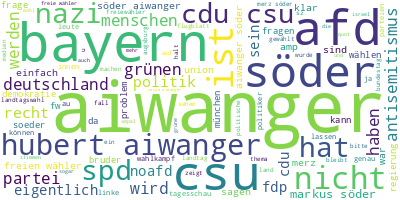

In [7]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
long_string = ",".join(german_sentiment_without_stop_words)
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=5, contour_color="steelblue")
wordcloud.generate(long_string)
wordcloud.to_image()

In [13]:
data_words = []

for words in german_sentiment_without_stop_words:
    doc = nlp(words.lower())
    data_words.append([x.lemma_.lower() for x in doc])
    
# filter for stopwords after lemmatizing again, just to make sure
data_words = [[x for x in data_word if x not in stop_words] for data_word in data_words] 
german_sentiment_df["lemma"] = data_words

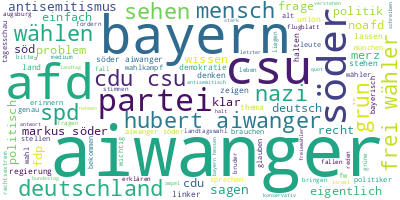

In [14]:
long_string = ",".join([x for data_word in data_words for x in data_word])
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=5, contour_color="steelblue")
wordcloud.generate(long_string)
wordcloud.to_image()

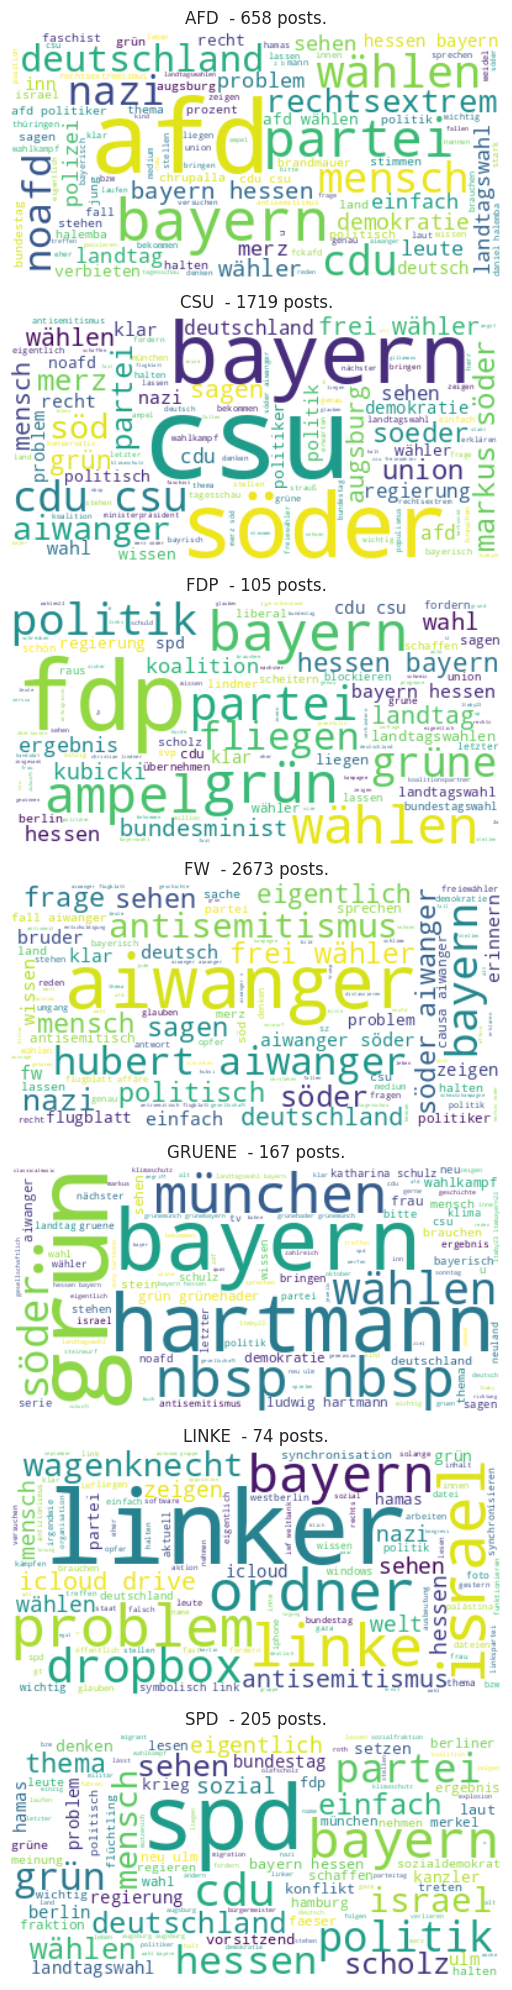

In [51]:
texts = german_sentiment_df.set_index("domentent_party").lemma
party_texts = {}
for i, v in texts.items():
    if i not in party_texts:
        party_texts[i] = [v]
    else:
        party_texts[i].append(v)
parties = set(german_sentiment_df.domentent_party)

fig, axs = plt.subplots(nrows=len(parties), ncols=1, figsize=(20, 20))

for i, party in enumerate(sorted(parties)):
    party_long_text = ",".join([word for text in party_texts[party] for word in text])
    wc = WordCloud(background_color="white", max_words=100, contour_width=5, contour_color="steelblue").generate(party_long_text)
    axs[i].imshow(wc, interpolation="bilinear")
    axs[i].set_title(f"{party.upper()}  - {len(party_texts[party])} posts.")
    axs[i].axis("off")
    
plt.tight_layout()
plt.show()

In [176]:
# Quelle: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# filter words that show up less than 15 times, more than 50% of the time and keep it to 10.000 Words
id2word.filter_extremes(no_below=15, no_above=0.50, keep_n=10000)

# Create Corpus
texts = data_words

# Term Document Frequency
# Converts a collection of words to  a list of (word_id, word_frequency) 2-tuples.
corpus = [id2word.doc2bow(text) for text in texts]
corpus[0]

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

In [177]:
def get_model(corpus, id2word, num_topics, random_state=0):
    return gensim.models.LdaMulticore(
        corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=random_state
    )

In [178]:
pyLDAvis.enable_notebook()

In [179]:
num_topics = 15
lda_model = get_model(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=2)
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.046859  0.041104       1        1  10.932927
7     -0.010789  0.020950       2        1   8.711822
1      0.007439 -0.000278       3        1   7.961187
10    -0.008528 -0.002494       4        1   7.646747
2      0.001572  0.008189       5        1   6.949876
6      0.036969 -0.055211       6        1   6.755722
0      0.013523 -0.017479       7        1   6.604982
4     -0.017911  0.013844       8        1   6.336855
12    -0.002796  0.044326       9        1   5.981338
14    -0.002639 -0.005550      10        1   5.941866
11     0.036742  0.011936      11        1   5.714807
13     0.002753 -0.080409      12        1   5.513238
8     -0.044552 -0.006846      13        1   5.345517
5     -0.059247 -0.010414      14        1   5.108349
3      0.094323  0.038332      15        1   4.494769, topic_info=          Term         Freq        Total Category  logprob  loglift
1060  augsburg   238.000000   238.000000  Default  30.0000  30.0000
12       s√∂der  1245.000000  1245.000000  Default  29.0000  29.0000
174        spd   286.000000   286.000000  Default  28.0000  28.0000
62         csu  1378.000000  1378.000000  Default  27.0000  27.0000
233        fdp   175.000000   175.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
197    einfach    11.775698   192.163720  Topic15  -5.3207   0.3099
149     w√§hler    12.533759   357.531174  Topic15  -5.2583  -0.2485
726     hessen    11.565133   235.198778  Topic15  -5.3387   0.0898
259       nazi    11.207370   221.438977  Topic15  -5.3701   0.1187
335      thema    10.292092   145.704555  Topic15  -5.4553   0.4521

[1002 rows x 6 columns], token_table=      Topic      Freq Term
term                      
862       1  0.185941    '
862       2  0.092970    '
862       3  0.092970    '
862       4  0.046485    '
862       5  0.139456    '
...     ...       ...  ...
545      11  0.023681    ü§∑
545      12  0.047363    ü§∑
545      13  0.071044    ü§∑
545      14  0.165769    ü§∑
545      15  0.047363    ü§∑

[6467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 2, 11, 3, 7, 1, 5, 13, 15, 12, 14, 9, 6, 4])